# Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['normal', 'moderate car damaged','minor damaged car','severe car damaged']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data


In [3]:
def load_data():

    datasets = [r'C:\Users\DELL\Music\car damaged detection 12\train', r'C:\Users\DELL\Music\car damaged detection 12\test']

    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\DELL\Music\car damaged detection 12\train


100%|██████████| 468/468 [00:01<00:00, 292.92it/s]


Loading C:\Users\DELL\Music\car damaged detection 12\test


100%|██████████| 180/180 [00:00<00:00, 278.03it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 2174
Number of testing examples: 420
Each image is of size: (150, 150)


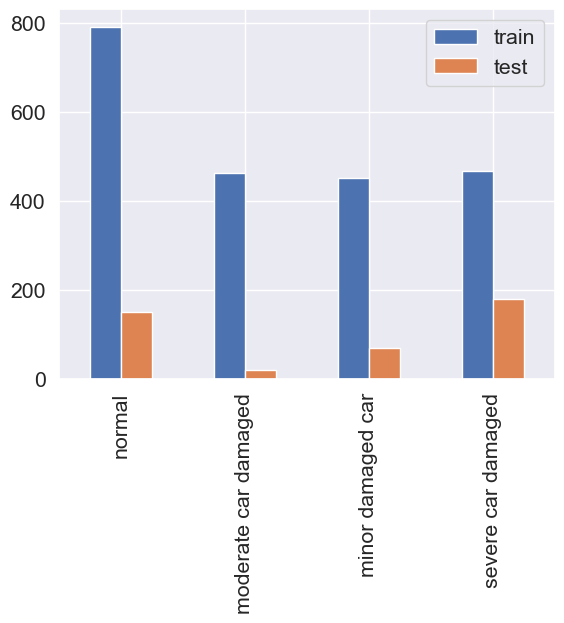

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

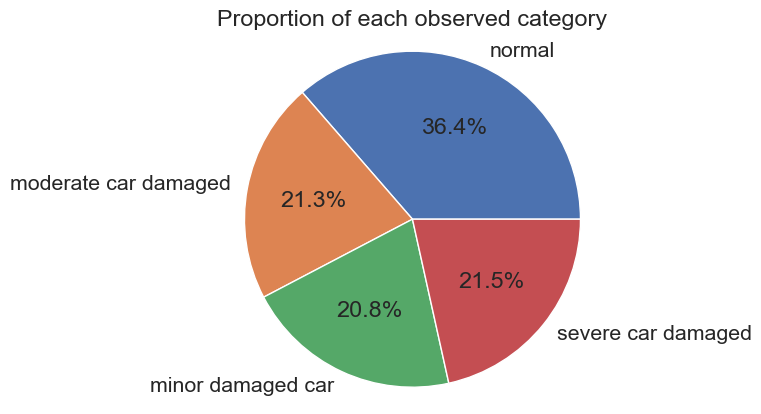

In [8]:
plt.pie(train_counts,
        explode=(0, 0,0,0) ,
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Visualize the data

In [10]:
def display_random_image(class_names, images, labels):


    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

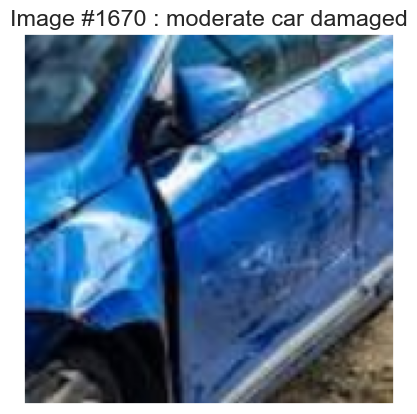

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

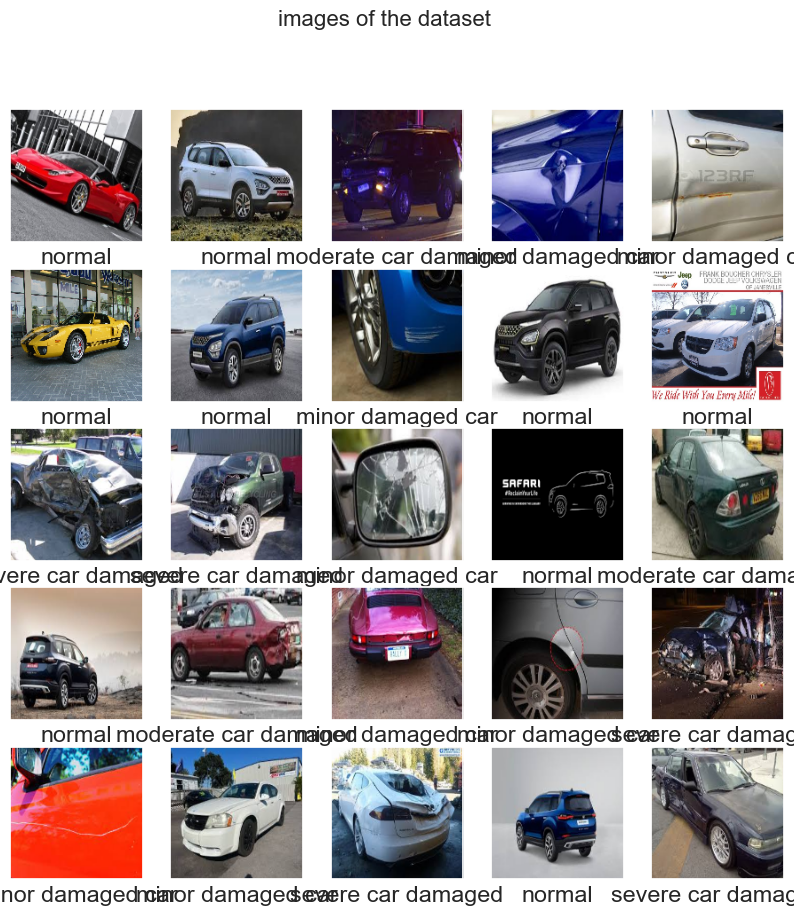

In [13]:
display_examples(class_names, train_images, train_labels)

In [14]:
batch_size =15
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

2/2 [==============================] - 1s 160ms/step
0 [D loss: 0.6357723501800212 | D accuracy: 50.0] [G loss: 28.702556610107422]
1/1 [==============================] - 0s 346ms/step


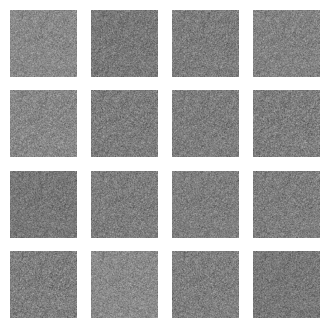

2/2 [==============================] - 0s 103ms/step


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# anomaly detection
def build_gan(latent_dim, input_shape):
    input_layer = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = Reshape(input_shape)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the discriminator model
def build_discriminator(input_shape):
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

# Combine the generator and discriminator into a GAN
def build_carinsurance_detector(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

normal_data = train_images


normal_data = (normal_data.astype(np.float32) - 127.5) / 127.5


np.random.seed(1000)
tf.random.set_seed(1000)
latent_dim = 100
input_shape = normal_data.shape[1:]

generator = build_gan(latent_dim, input_shape)
discriminator = build_discriminator(input_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

discriminator.trainable = False
gan = build_carinsurance_detector(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

epochs = 10
batch_size = 64

for epoch in range(epochs):
    # Select a random batch of normal data
    idx = np.random.randint(0, normal_data.shape[0], batch_size)
    real_images = normal_data[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    # Train the discriminator
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (discriminator weights are frozen)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress and save generated images at checkpoints
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Generate and save generated images
        generated_images = generator.predict(np.random.normal(0, 1, (16, latent_dim)))
        generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]
        fig, axs = plt.subplots(4, 4, figsize=(4, 4))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
       
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(4, activation=tf.nn.softmax)
        ])
        model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


In [16]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
14/14 [==============================] - 43s 3s/step - loss: 2.4177 - accuracy: 0.2524 - val_loss: 1.3462 - val_accuracy: 0.3563
Epoch 2/10
14/14 [==============================] - 35s 2s/step - loss: 1.3280 - accuracy: 0.3657 - val_loss: 1.3008 - val_accuracy: 0.3586
Epoch 3/10
14/14 [==============================] - 34s 2s/step - loss: 1.2186 - accuracy: 0.3979 - val_loss: 1.1996 - val_accuracy: 0.4575
Epoch 4/10
14/14 [==============================] - 39s 3s/step - loss: 1.0434 - accuracy: 0.5474 - val_loss: 1.1154 - val_accuracy: 0.5517
Epoch 5/10
14/14 [==============================] - 40s 3s/step - loss: 0.8933 - accuracy: 0.6360 - val_loss: 1.1309 - val_accuracy: 0.5471
Epoch 6/10
14/14 [==============================] - 42s 3s/step - loss: 0.6729 - accuracy: 0.7453 - val_loss: 1.1097 - val_accuracy: 0.5425
Epoch 7/10
14/14 [==============================] - 45s 3s/step - loss: 0.5204 - accuracy: 0.8235 - val_loss: 1.1464 - val_accuracy: 0.5402
Epoch 8/10
14/14 [==

In [17]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

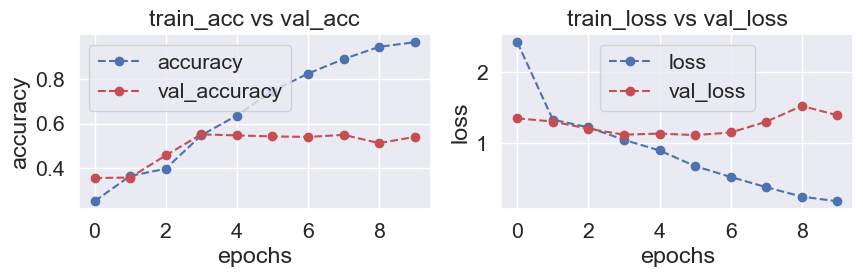

In [18]:
plot_accuracy_loss(history)

In [19]:
test_loss = model.evaluate(test_images, test_labels)

14/14 [==============================] - 3s 166ms/step - loss: 0.4201 - accuracy: 0.8952


1/1 [==============================] - 0s 255ms/step
[2]


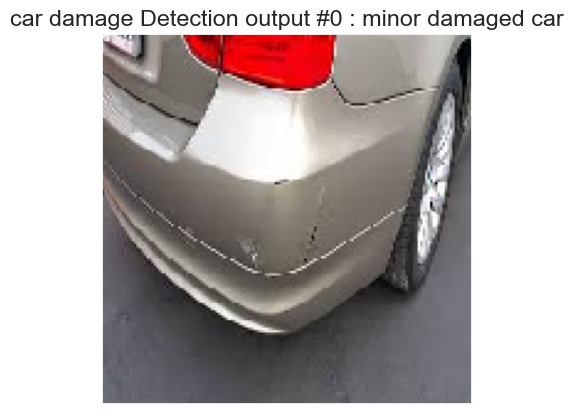

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
test_image = image.load_img(r'C:\Users\DELL\Music\car damaged detection 12\test\minor damaged car/0003.jpeg', target_size = (150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
predictions = model.predict(test_image)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
print(pred_labels )
index = np.random.randint(test_image.shape[0])
plt.figure()
plt.imshow(test_image[index].astype('uint8'))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('car damage Detection output #{} : '.format(index) + class_names[pred_labels[index]])
plt.show()

14/14 [==============================] - 4s 263ms/step


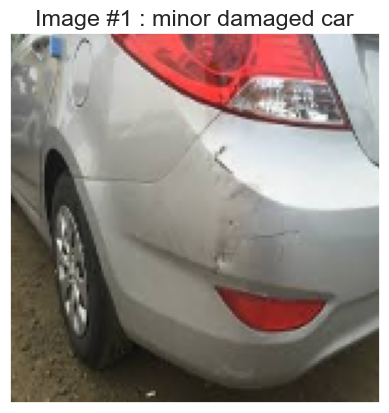

In [21]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

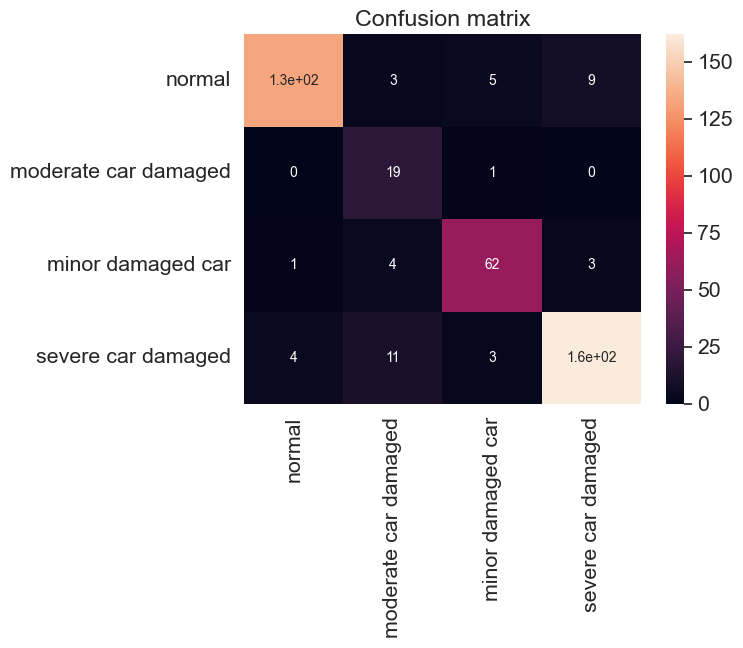

In [22]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true contains true labels and y_pred contains predicted labels
y_true = [0, 1, 0, 1]
y_pred = [0, 1, 1, 1]

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

Accuracy: 0.75
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8


In [24]:
from sklearn.metrics import classification_report
print("\n Classification report : \n {}".format(classification_report(test_labels, pred_labels)))


 Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       150
           1       0.51      0.95      0.67        20
           2       0.87      0.89      0.88        70
           3       0.93      0.90      0.92       180

    accuracy                           0.90       420
   macro avg       0.82      0.91      0.85       420
weighted avg       0.91      0.90      0.90       420



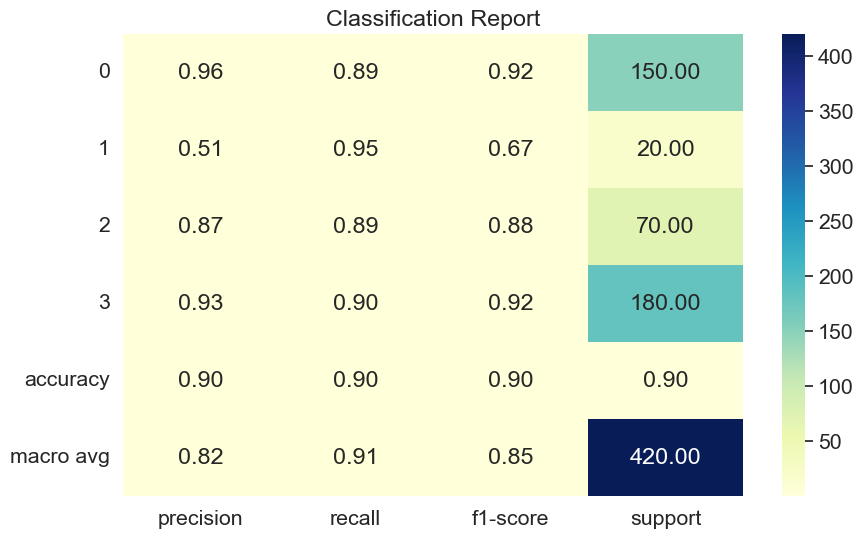

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Assuming test_labels and pred_labels are available

# Generate classification report
report = classification_report(test_labels, pred_labels, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report')
plt.show()

In [26]:
model.save_weights("model_vgg.weights.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
model_json=model.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [29]:
import os
import numpy as np
import tensorflow as tf
from flask import Flask, render_template, request, redirect, url_for, session, send_from_directory, flash
from keras.models import model_from_json
from keras.preprocessing import image

app = Flask(__name__)
app.secret_key = os.urandom(24).hex()

UPLOAD_FOLDER = "uploads"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Ensure upload folder exists
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)

# Load Model
try:
    with open('model_vgg.json', 'r') as json_file:
        loaded_model_json = json_file.read()
    
    cnn_model = model_from_json(loaded_model_json)
    cnn_model.load_weights("model_vgg.h5")
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# User Database (Use a real database & bcrypt for security)
users_db = {}

IMAGE_SIZE = 150

def preprocess_image(image_path):
    try:
        img = image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def classify(model, image_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        return "Error", 0
    prob = model.predict(img_array)[0]
    predicted_label_index = np.argmax(prob)
    label_names = ['normal', 'moderate car damaged', 'minor damaged car', 'severe car damaged']
    return label_names[predicted_label_index], round(prob[predicted_label_index] * 100, 2)

@app.route("/")
def home():
    if 'username' not in session:
        return redirect(url_for('login'))
    return render_template("home.html")

@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        
        if username in users_db:
            flash("Username already exists!", "danger")
            return redirect(url_for('register'))
        
        users_db[username] = password
        flash("Registration successful! Please login.", "success")
        return redirect(url_for('login'))  # Redirect to login after registration
    
    return render_template('register.html')

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        
        if username in users_db and users_db[username] == password:
            session['username'] = username
            flash("Login successful!", "success")
            return redirect(url_for('home'))  # Redirect to home after login
        
        flash("Invalid credentials, try again.", "danger")
    
    return render_template('login.html')

@app.route('/logout')
def logout():
    session.pop('username', None)
    flash("Logged out successfully.", "info")
    return redirect(url_for('login'))

@app.route("/classify", methods=["POST", "GET"])
def upload_file():
    if 'username' not in session:
        flash("Please login first!", "warning")
        return redirect(url_for('login'))  # Ensure user is logged in before classifying

    if request.method == "GET":
        return render_template("home.html")

    if 'image' not in request.files:
        flash("No file uploaded!", "danger")
        return redirect(url_for('home'))

    file = request.files["image"]
    
    if file.filename == "":
        flash("No selected file.", "warning")
        return redirect(url_for('home'))

    upload_image_path = os.path.join(UPLOAD_FOLDER, file.filename)
    file.save(upload_image_path)

    label, prob = classify(cnn_model, upload_image_path)
    
    if label == "Error":s
        flash("Error processing the image.", "danger")
        return redirect(url_for('home'))

    return render_template("classify.html", image_file_name=file.filename, label=label, prob=prob)

@app.route("/classify/<filename>")
def send_file(filename):
    return send_from_directory(UPLOAD_FOLDER, filename)

if __name__ == "__main__":
    app.run()


Error loading model: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_vgg.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Mar/2025 19:12:49] "GET / HTTP/1.1" 302 -
127.0.0.1 - - [28/Mar/2025 19:12:49] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:12:56] "GET /register HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:09] "POST /register HTTP/1.1" 302 -
127.0.0.1 - - [28/Mar/2025 19:13:09] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:17] "POST /login HTTP/1.1" 302 -
127.0.0.1 - - [28/Mar/2025 19:13:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:17] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2025 19:13:17] "GET /static/images/bg.jpg HTTP/1.1" 304 -


1/1 [==============================] - 0s 246ms/step


127.0.0.1 - - [28/Mar/2025 19:13:28] "POST /classify HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:29] "GET /classify/1dbc1bd213e74c8598e6874de9b55c53_thb.jpg HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:29] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2025 19:13:29] "GET /static/images/car_insurance.jpg HTTP/1.1" 404 -
127.0.0.1 - - [28/Mar/2025 19:13:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2025 19:13:33] "GET /static/images/bg.jpg HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2025 19:13:33] "GET /static/script.js HTTP/1.1" 304 -
